In [1]:
from google.colab import files
uploaded = files.upload()

Saving combined_dataframe.xlsx to combined_dataframe.xlsx


In [2]:
import pandas as pd

df = pd.read_excel('combined_dataframe.xlsx')
print(df.shape)
df.head()

(207, 42)


,Sex_df1,Age (Years) (Binned)_df1,Race_df1,Baseline eGFR (ml/min/1.73m2)_df1,Proteinuria (mg) (Binned)_df1,A1c (%) (Binned)_df1,Albuminuria (mg) (Binned)_df1,Diabetes History_df1,Diabetes Duration (Years)_df1,Hypertension History_df1,...,Chloride (mEq/L),Calcium (mg/dL),Cystatin C (mg/L),Participant_ID_norm,Urine Creatinine (mg/dL),Urine Albumin (mg/dL),Urine Protein (mg/dL),ACR (mg/g),PCR (mg/g),Creatinine_Index_mgkgday
0,Female,60-69 Years,White,44.833049,NaN,>=8.5%,500 to <1000 mg/g cr,Yes,30-34 Years,Yes,...,101.0,9.5,2.03522,27-10039,42.9,19.00,34.0,442.89000,792.540000,11.508197
1,Female,60-69 Years,Asian,60.392502,NaN,>=8.5%,30 to <300 mg/g cr,Yes,25-29 Years,Yes,...,100.0,10.1,1.73246,27-10041,19.8,1.84,15.0,92.93000,757.580000,8.583318
2,Female,50-59 Years,White,36.830792,NaN,>=8.5%,30 to <300 mg/g cr,Yes,25-29 Years,Yes,...,104.0,9.2,1.66518,27-10042,36.1,2.54,11.0,70.36000,304.710000,11.990392
3,Female,40-49 Years,White,111.332580,NaN,>=8.5%,>=1000 mg/g cr,Yes,20-24 Years,Yes,...,101.0,10,0.91669,27-10043,45.7,23.74,36.0,519.47000,787.750000,12.381096
4,Male,60-69 Years,White,61.916617,NaN,7.5 to <8.5%,30 to <300 mg/g cr,Yes,55-59 Years,No,...,98.0,8.9,1.34000,27-10047,48.7,21.04,34.0,429.94012,678.642715,8.298779


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for preprocessing & pipelines
from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#for unsupervised learning
from sklearn.cluster import KMeans

#for clustering evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [4]:
#make a copy of original df
df0 = df.copy()

#drop participant id column
df0 = df0.drop(columns=["Participant_ID_norm"])

df0.shape

(207, 41)

In [5]:
#define numeric vs categorical columns
num_col = ["Baseline eGFR (ml/min/1.73m2)_df1",
           "eGFRCr",
           "eGFRCys",
           "eGFRCrCys",
           "Albumin (g/dL)",
           "Alkaline phosphatase (U/L)",
           "Alanine aminotransferase (U/L)",
           "Aspartate aminotransferase (U/L)",
           "Carbon dioxide (mEq/L)",
           "Total bilirubin (mg/dL)",
           "Direct bilirubin (mg/dL)",
           "Blood urea nitrogen (mg/dL)",
           "Creatinine (mg/dL)",
           "Glucose (mg/dL)",
           "Phosphate (mg/dL)",
           "C-reactive protein (high sensitivity) (mg/L)",
           "Magnesium (mg/dL)",
           "Total protein (g/dL)",
           "Uric acid (mg/dL)",
           "Sodium (mEq/L)",
           "Potassium (mEq/L)",
           "Chloride (mEq/L)",
           "Calcium (mg/dL)",
           "Cystatin C (mg/L)",
           "Urine Creatinine (mg/dL)",
           "Urine Albumin (mg/dL)",
           "Urine Protein (mg/dL)",
           "ACR (mg/g)",
           "PCR (mg/g)",
           "Creatinine_Index_mgkgday"]

cat_col = ["Sex_df1",
           "Age (Years) (Binned)_df1",
           "Race_df1",
           "Proteinuria (mg) (Binned)_df1",
           "A1c (%) (Binned)_df1",
           "Albuminuria (mg) (Binned)_df1",
           "Diabetes History_df1",
           "Diabetes Duration (Years)_df1",
           "Hypertension History_df1",
           "Hypertension Duration (Years)_df1",
           "On RAAS Blockade_df1"]

In [6]:
#check total column number should be 41
print(f"Numeric columns: {len(num_col)}")
print(f"Categorical columns: {len(cat_col)}")

Numeric columns: 30
Categorical columns: 11


In [7]:
#get rid of placeholders in numeric columns
placeholders = ["QNS", "Invalid"]
df0[num_col] = df0[num_col].replace(placeholders, np.nan)

#convert categorical columns to strings (prevents downstream errors)
for col in cat_col:
    df0[col] = df0[col].astype(str)

**Create preprocessing pipeline using sklearn for:**
*   Imputation (filling in missing values)
*   Encoding (converting categorical features to numeric for ML)
*   Scaling (standardize all features)






In [8]:
numeric_pipe = Pipeline(steps=[("impute", IterativeImputer(random_state=42, sample_posterior=True)),("scale", RobustScaler())])

categorical_pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

pre = ColumnTransformer(transformers=[("num", numeric_pipe, num_col),("cat", categorical_pipe, cat_col),],remainder="drop")

**Run preprocessing pipeline:**

In [9]:
clean_data = pre.fit_transform(df0)
clean_data.shape

(207, 96)

In [10]:
#get all column names after transformation
feature_names = pre.get_feature_names_out()
print("Total transformed features:", len(feature_names))
#print("Feature names:", feature_names)
print("num features:", sum(name.startswith("num__") for name in feature_names))
print("cat features:", sum(name.startswith("cat__") for name in feature_names))

Total transformed features: 96
num features: 30
cat features: 66


**k-means clustering (unsupervised ML):**

,k,silhouette,davies_bouldin
0,2,0.993065,0.001451
1,3,0.486965,0.671888
2,4,0.297600,1.376759
5,7,0.089016,1.472013
3,5,0.081015,1.760038
4,6,0.077278,1.685561
6,8,0.076442,1.643745
7,9,0.049882,1.817546
8,10,0.044376,1.834662


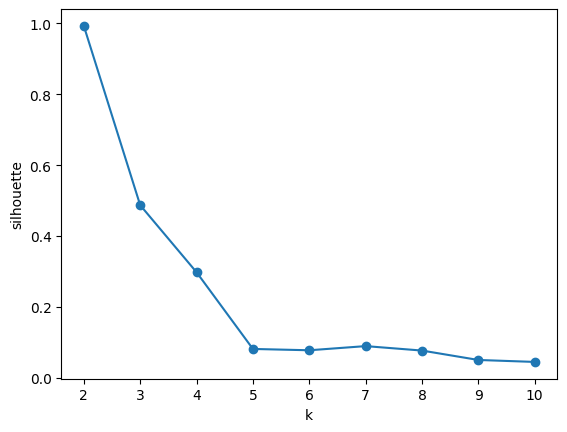

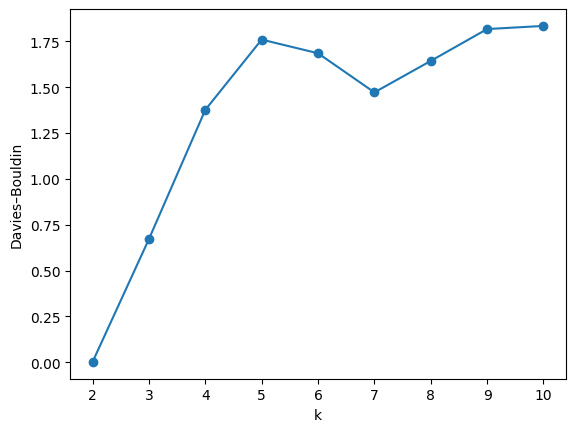

In [12]:
#test different number of k clusters
results = []
for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(clean_data)
  sil = silhouette_score(clean_data, labels)
  db  = davies_bouldin_score(clean_data, labels)
  results.append((k, sil, db))

results_df = pd.DataFrame(results, columns=["k","silhouette","davies_bouldin"])
display(results_df.sort_values("silhouette", ascending=False))

plt.figure(); plt.plot(results_df.k, results_df.silhouette, marker="o"); plt.xlabel("k"); plt.ylabel("silhouette"); plt.show()
plt.figure(); plt.plot(results_df.k, results_df.davies_bouldin, marker="o"); plt.xlabel("k"); plt.ylabel("Davies–Bouldin"); plt.show()

Clustering performance evaluated with silhouette score and Davies-Bouldin Index (DBI). Silhouette score tells us how clearly the clusters are separated (higher score means the groups are well-defined and different from each other). DBI tells us how similar the clusters are to each other (lower score means points within a cluster are similar to each other and that each cluster is clearly separated from each other).

Both evaluation metrics show two clusters (k=2) fit the data the best, indicating participants fall into two main CKD subgroups based on their clinical and biomarker patterns.

BUTTTTTTTT...

In [13]:
best_k = 2
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(clean_data)

df_clusters = df0.copy()
df_clusters["Cluster"] = cluster_labels
print(df_clusters["Cluster"].value_counts().sort_index())


Cluster
0    206
1      1
Name: count, dtype: int64


This is telling us there are 206 participants in one cluster and 1 in the the other....doesn't make sense. Could this be an outlier?

Analysis redone for potential outlier?:

,Sex_df1,Age (Years) (Binned)_df1,Race_df1,Baseline eGFR (ml/min/1.73m2)_df1,Proteinuria (mg) (Binned)_df1,A1c (%) (Binned)_df1,Albuminuria (mg) (Binned)_df1,Diabetes History_df1,Diabetes Duration (Years)_df1,Hypertension History_df1,...,Potassium (mEq/L),Chloride (mEq/L),Calcium (mg/dL),Cystatin C (mg/L),Urine Creatinine (mg/dL),Urine Albumin (mg/dL),Urine Protein (mg/dL),ACR (mg/g),PCR (mg/g),Creatinine_Index_mgkgday
206,Male,60-69 Years,Black or African-American,30.46343,>=1000 mg/g cr,>=8.5%,>=1000 mg/g cr,Yes,20-24 Years,Yes,...,NaN,104.0,8.4,2.01,0.1,176.64,331.0,1808000.0,3310000.0,NaN


Removed 1 outlier participant(s). Remaining: 206


,k,silhouette,davies_bouldin
0,2,0.484004,0.978888
1,3,0.454017,1.170696
2,4,0.263501,1.298091
4,6,0.101053,1.645875
3,5,0.098198,1.862272
5,7,0.088397,1.711581
6,8,0.086324,1.697640
8,10,0.086127,1.588245
7,9,0.069968,1.821242


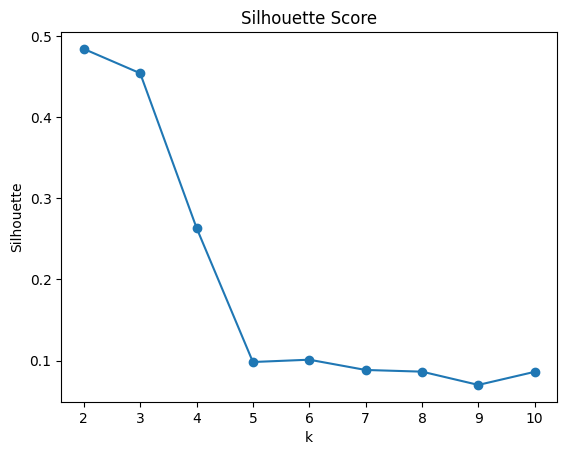

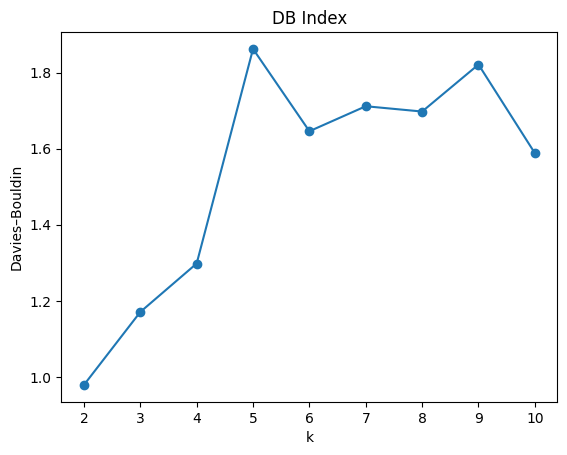

New cluster sizes:
 Cluster
0    192
1     14
Name: count, dtype: int64


In [15]:
#check for outlier participant
outlier_row = df0.loc[df_clusters["Cluster"] == 1]
display(outlier_row)

#remove participant
df_cleaned = df0.loc[df_clusters["Cluster"] != 1].copy()
print(f"Removed {len(outlier_row)} outlier participant(s). Remaining: {len(df_cleaned)}")

#redo preprocessing
clean_data2 = pre.fit_transform(df_cleaned)

#redo k means clustering
results = []
for k in range(2, 11):
  km = KMeans(n_clusters=k, n_init=30, random_state=42)
  labels = km.fit_predict(clean_data2)
  sil = silhouette_score(clean_data2, labels)
  db  = davies_bouldin_score(clean_data2, labels)
  results.append((k, sil, db))

results_df2 = pd.DataFrame(results, columns=["k","silhouette","davies_bouldin"])
display(results_df2.sort_values("silhouette", ascending=False))

plt.figure()
plt.plot(results_df2.k, results_df2.silhouette, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette Score")
plt.show()

plt.figure()
plt.plot(results_df2.k, results_df2.davies_bouldin, marker="o")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin"); plt.title("DB Index")
plt.show()

#fit final model with new best k and check cluster sizes
best_k2 = int(results_df2.sort_values("silhouette", ascending=False).iloc[0]["k"])
final_kmeans2 = KMeans(n_clusters=best_k2, n_init=30, random_state=42)
labels2 = final_kmeans2.fit_predict(clean_data2)

df_clusters2 = df_cleaned.copy()
df_clusters2["Cluster"] = labels2
print("New cluster sizes:\n", df_clusters2["Cluster"].value_counts().sort_index())

Two cluster. One cluster has 192 and the other has 14 participants. Is this real data or due to other factors like biopsy collection, etc....